# Embedding

In [95]:
# load libraries
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import offsetbox
import seaborn as sns
sns.set_theme(style="darkgrid")

import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
import sklearn.cluster
from sklearn.metrics import pairwise_distances 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

import scipy.spatial 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# data
data_path = '/glade/u/home/cassiacai/marine_heatwaves/notebooks/SSTA_and_events_0_3.nc'
event_file =  xr.open_dataset(data_path)

In this example, we will work with 
1. mean intensity images
2. cumulative intensity images
3. total spatial extent (which is a binary image)

In [3]:
## --- 1. Mean Intensity Images
# mean_intensity_images = np.zeros((1204,192,288))

# for obj_id in range(1,1204):
#     one_obj = np.asarray(event_file.where(event_file.labels==obj_id, 
#                                           drop=False).mean(dim='time').SSTA.values)
#     mean_intensity_images[obj_id] = one_obj

# np.save('mean_intensity_images.npy', np.array(mean_intensity_images, dtype=object), allow_pickle=True)

In [4]:
mean_intensity_images = np.load('mean_intensity_images.npy', allow_pickle=True)
print(mean_intensity_images.shape)

(1204, 192, 288)


In [5]:
## --- 2. Cumulative Intensity Images
# sum_intensity_images = np.zeros((1204,192,288))

# for obj_id in range(1,1204):
#     print(obj_id)
#     one_obj = np.asarray(event_file.where(event_file.labels==obj_id, 
#                                           drop=False).sum(dim='time').SSTA.values)
#     sum_intensity_images[obj_id] = one_obj

# np.save('sum_intensity_images.npy', np.array(sum_intensity_images, dtype=object), allow_pickle=True)

In [6]:
sum_intensity_images = np.load('sum_intensity_images.npy', allow_pickle=True)
print(sum_intensity_images.shape)

(1204, 192, 288)


In [30]:
binary = np.where(sum_intensity_images[:,:,:] > 0., 1., 0.)

In [151]:
## --- 3. Total Spatial Extent (which is a binary image)
tsebinary_images = np.where(sum_intensity_images[:,:,:] > 0., 1., 0.)

In [175]:
## --- Pre-processing step
data_path = '/glade/u/home/cassiacai/marine_heatwaves/notebooks/one_val_data.csv'
df = pd.read_csv(data_path) # shape: (1,13)

# cleaning
measures = list(df.columns)
measure_np = np.zeros((df.shape[1],1203))
for measure_i in range(len(measures)):
    ls_measure = df[measures[measure_i]][0][1:-1].split(', ')
    measure_np[measure_i] = [float(i) for i in ls_measure]

# create attributes dataframe
attributes_df = pd.DataFrame({ measures[i]: measure_np[i] for i in range(len(measures)) })

# 1. remove all short 1-month long MHWs
image_array = mean_intensity_images # replace this with whatever you want to use

longerthan1_df = attributes_df.loc[attributes_df['duration'] > 1]
index_longerthan1 = list(short_1_month_htws_df.index)
longerthan1_array = image_array[1:][index_longerthan1,:,:]

# 2. separate by basin

In [176]:
X = longerthan1_array[1:] # can be replaced by sum_intensity_images[1:], tsebinary_images[1:], mean_intensity_images[1:]
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # reshape so that is a 2D
X = MinMaxScaler().fit_transform(X) 

# --- Note
# Standard Scaler -  Transforms features independently to unit variance and zero centered. Its data 
#                    value range is fixed between 0 and 1 . Most commonly used.
# MinMax Scaler -    Alternate to standard scaling which has agility to set the minimum and maximum 
#                    range of data value. e.g. -1 to +1, -10 to +10. Min max scaler should be used 
#                    when it is required to capture small variance in features and also for sparse 
#                    data where zero value needs to be preserved.

X[X!=X] = 0 # we don't want nans
print(X.shape)

(670, 55296)


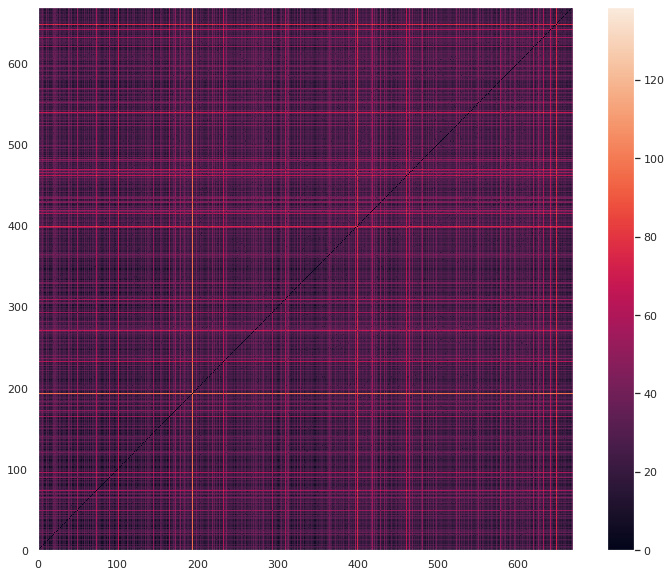

[  1   0 110  64 162 317  96  10 111 102]


(-63.088648597812266, 86.3895904659975, -67.7272640647709, 132.8274903372145)

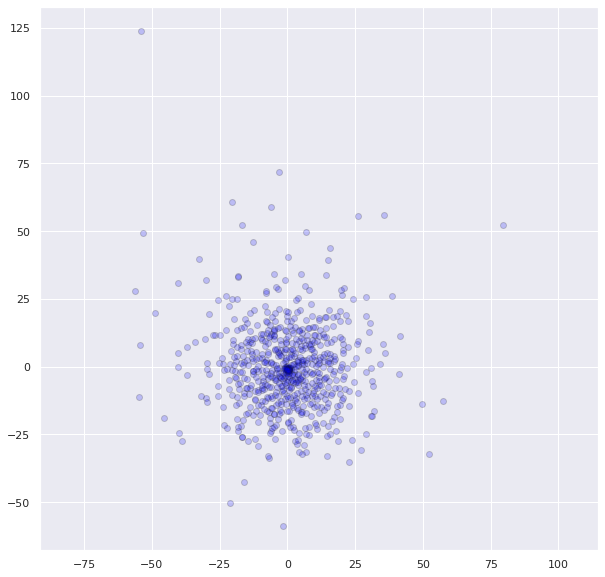

In [ ]:
### --- trying something
D = pairwise_distances(X, metric='euclidean') # metric options are: ‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’ among others

fig = plt.figure(figsize=(12,10)) 
plt.pcolormesh(D); plt.colorbar()
plt.show()

obj_id = 1
most_similar = np.argsort(D[obj_id])[:10]
print(most_similar) # these are the most similar 10 objects to the obj_id

# While computing this distance matrix from the (x,y) coordinates is straightforward, transforming back into
# x and y coordinates is rather difficult. This is exactly what the multidimensional scaling algorithm
# aims to do: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation
# of the data. 
#
# Let's see how it works for our distance matrix, using the precomputed dissimilarity to specify that we are
# passing a distance matrix.
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

fig = plt.figure(figsize=(10,10)) 
plt.scatter(out[:, 0], out[:, 1], alpha=0.2, c='blue', edgecolor='k')
plt.axis('equal')

### PCA on images

In [182]:
# X = tsebinary_images[1:] # we don't take the first image because it is an image full of 0s
X = longerthan1_array # we don't take the first image because it is an image full of 0s
# can be replaced by sum_intensity_images[1:], tsebinary_images[1:], mean_intensity_images[1:]
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X = MinMaxScaler().fit_transform(X)
X = np.nan_to_num(X)

mean_data = np.mean(X,0)
centered_X = X - mean_data

In [183]:
N = 20

In [ ]:
# elbow plot
KK = np.arange(1,N)
WSS = []

for j in range(len(KK)):
    KMM = skl.cluster.KMeans(n_clusters=KK[j], random_state=0)
    KMM.fit(centered_X)
    centroids = KMM.cluster_centers_
    Y_pred = KMM.labels_
  # compute WSS 
    wss = 0
    for i in range(N):
        current_cents = centroids[Y_pred[i]]
        wss += np.linalg.norm( centered_X[i] - current_cents )**2
    WSS.append(wss)

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
plt.plot(KK, WSS)
plt.xlabel('K'); plt.ylabel('WSS(K)')
plt.show()

In [ ]:
pca = PCA(n_components = 4)
pca.fit(centered_X)

frobenius_norm = np.sqrt(sum(pca.singular_values_**2))
print(frobenius_norm)

# --- Note
# The Frobenius norm (also called the Euclidean norm) is matrix norm of an m×n matrix A 
# defined as the square root of the sum of the absolute squares of its elements.

In [ ]:
transformed = pca.fit_transform(centered_X)

In [ ]:
transformed_df = pd.DataFrame(data = transformed, columns = ['PC1', 'PC2','PC3','PC4'])

In [ ]:
components_reshaped = pca.components_.reshape(4, 192, 288)

In [ ]:
plt.rcParams["figure.figsize"] = (25,12)

plt.subplot(2, 2, 1)
plt.title('EOF1', fontsize=15)
plt.contourf(components_reshaped[0,:,:], cmap='seismic')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('EOF2', fontsize=15)
plt.contourf(components_reshaped[1,:,:], cmap='seismic')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('EOF3', fontsize=15)
plt.contourf(components_reshaped[2,:,:], cmap='seismic')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('EOF4', fontsize=15)
plt.contourf(components_reshaped[3,:,:], cmap='seismic')
plt.colorbar()

plt.show()

In [ ]:
nuclear_norm = np.linalg.norm(pca.singular_values_) # is the sum of singular singulars
sv_scaled = pca.singular_values_**2/(nuclear_norm**2) 
sv_scaled = pca.explained_variance_ratio_
sv_total = np.cumsum(pca.singular_values_**2)/(nuclear_norm**2)

In [ ]:
plt.rcParams["figure.figsize"] = (25,6)

plt.subplot(1, 4, 1)
plt.plot(sv_scaled, 'blue') # equivalent to pca.explained_variance_ratio_
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('explained variance ratio', fontsize=15)

plt.subplot(1, 4, 2)
plt.plot(sv_total, 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.subplot(1, 4, 3)
plt.plot(sv_total[:30], 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.subplot(1, 4, 4)
plt.plot(np.log(sv_scaled),'blue') # equivalent to np.log(pca.singular_values_)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('log(explained variance ratio)', fontsize=15)

plt.show()

In [ ]:
def no_pca_modes(ratio):
    pca_test = PCA(n_components=1)
    pca_test.fit(centered_X)
    np.sqrt(sum(pca_test.singular_values_**2))
    i = 1
    while np.sqrt(sum(pca_test.singular_values_**2)) < ratio*frobenius_norm:
        i += 1
        pca_test = PCA(n_components=i)
        pca_test.fit(centered_X)
    return i

print('Number of PCA modes to keep to approximate X_train up to 60%: ', no_pca_modes(0.6))
print('Number of PCA modes to keep to approximate X_train up to 80%: ',no_pca_modes(0.8))
print('Number of PCA modes to keep to approximate X_train up to 90%: ',no_pca_modes(0.9))

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
pd.plotting.scatter_matrix(transformed_df,alpha=0.4)
plt.show()

In [ ]:
fig, ax = plt.subplots()

plt.axhline(y=0, c='k', alpha=0.4)
plt.axvline(x=0, c='k', alpha=0.4)
scatter = ax.scatter(transformed_df.PC1, transformed_df.PC2,c=Y_pred, alpha=0.5, edgecolor='k', cmap='tab10')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", bbox_to_anchor=(1.2, 1.0), title="Classes")
ax.add_artist(legend1)
plt.xlabel('PC1', fontsize=15); plt.ylabel('PC2', fontsize=15)
# plt.xlim(-0.6, 1.5); plt.ylim(-0.6, 1.5)
plt.show()

In [ ]:
n_components = 2 # # We want to get TSNE embedding with 2 dimensions
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(centered_X)
 
#Plot the result of our TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 
                               'tsne_2': tsne_result[:,1],
                               'label': Y_pred})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', 
                y='tsne_2', 
                hue='label', 
                data=tsne_result_df, 
                ax=ax,s=120,
                alpha=0.5, 
                palette='bright')
lim = (tsne_result.min()-5, 
       tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), 
          loc=2, borderaxespad=0.0)
plt.show()

In [ ]:
u_left = tsne_result_df.loc[(tsne_result_df.tsne_1 < 0) & (tsne_result_df.tsne_2 > 0)]
print(len(u_left))

u_right = tsne_result_df.loc[(tsne_result_df.tsne_1 > 0) & (tsne_result_df.tsne_2 > 0)]
print(len(u_right))

l_left = tsne_result_df.loc[(tsne_result_df.tsne_1 < 0) & (tsne_result_df.tsne_2 < 0)]
print(len(l_left))

l_right = tsne_result_df.loc[(tsne_result_df.tsne_1 > 0) & (tsne_result_df.tsne_2 < 0)]
print(len(l_right))

In [ ]:
images = mean_intensity_images[1:]
images[images!=images] = 0

print(type(images))
print(images.shape)

images = images[:,:,:].astype(float)
print(images.shape)

smaller_img = images[:,::4, ::4] # decrease the resolution 
print(smaller_img.shape)

In [ ]:
plt.rcParams["figure.figsize"] = (12.5,6)

plt.subplot(1, 2, 1)
plt.contourf(smaller_img[1201,:,:])

plt.subplot(1, 2, 2)
plt.contourf(images[1201,:,:])

plt.show()

In [ ]:
transformed = tsne_result # can delete this if we don't want tsne_result
transformed = MinMaxScaler().fit_transform(transformed)

In [ ]:
transformed

In [ ]:
_, ax = plt.subplots(figsize=(25,25))

shown_images = np.array([[1.0, 1.0]])  # just something big
for i in range(transformed.shape[0]):
    dist = np.sum((transformed[i,:] - shown_images) ** 2, 1)
    # if np.min(dist) < 4e-2:
    #         # don't show points that are too close
    #     continue
    shown_images = np.concatenate([shown_images, [transformed[i]]], axis=0)
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(smaller_img[i,:,:], cmap=plt.cm.gray_r), transformed[i]
        )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

ax.set_title('title')
ax.axis("on")

In [ ]:
# plotly hover

Resources
- https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.locally_linear_embedding.html#sklearn.manifold.locally_linear_embedding
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [ ]:
# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line

ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])

ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')

plt.show()